In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
import numpy as np
import os

# Load the image dataset
data_dir = "/content/drive/MyDrive/VAE/train"
img_height = 512
img_width = 512
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    ,labels=None)

def normalize(x):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    #x = (x - 0.5) * 2.0
    return x

def denormalize(x):
    #x = x / 2.0 + 0.5
    x = x * 255.0
    #x = tf.cast(x, tf.uint8)
    return x


train_ds = train_ds.map(normalize)

#train_ds = train_ds.map(lambda x: x/255.0)

#train_ds = train_ds.map(lambda x: (tf.image.resize(x, (img_height, img_width)) - 0.5) * 2)

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5000 files belonging to 1 classes.
Using 4000 files for training.


In [ ]:
min_val = 1.0
max_val = 0.0
for x in train_ds:
    min_val = tf.reduce_min(x).numpy()
    max_val = tf.reduce_max(x).numpy()
    
print(f"Minimum pixel value: {min_val:.4f}")
print(f"Maximum pixel value: {max_val:.4f}")

In [5]:
import tensorflow.keras.backend as K
import tensorflow as tf

initializer = tf.keras.initializers.GlorotNormal()


latent_dim = 10

encoder_inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same",kernel_initializer=initializer)(encoder_inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation="relu",kernel_initializer=initializer)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu",kernel_initializer=initializer)(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64, activation="relu",kernel_initializer=initializer)(x)
x = tf.keras.layers.Dropout(0.2)(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean",kernel_initializer=initializer)(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var",kernel_initializer=initializer)(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

#latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
latent_inputs1 = tf.keras.layers.Input(shape=(latent_dim,))
latent_inputs2 = tf.keras.layers.Input(shape=(latent_dim,))
latent_inputs = tf.keras.layers.concatenate([latent_inputs1, latent_inputs2])
x = tf.keras.layers.Dense(64, activation="relu",kernel_initializer=initializer)(latent_inputs)
x = tf.keras.layers.Dense(img_height//4 * img_width//4 * 3, activation="relu",kernel_initializer=initializer)(x)
x = tf.keras.layers.Reshape((img_height//4, img_width//4, 3))(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same",kernel_initializer=initializer)(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", padding="same",kernel_initializer=initializer)(x)
x = tf.keras.layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same",kernel_initializer=initializer)(x)

decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same",kernel_initializer=initializer)(x)

decoder = tf.keras.Model([latent_inputs1, latent_inputs2], decoder_outputs, name="decoder")




class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100,))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Define the VAE model
vae = VAE(encoder, decoder)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    kl_losses = []
    for step, x in enumerate(train_ds):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = vae.encode(x)
            #z = vae.reparameterize(z_mean, z_log_var)
            #x_recon = vae.decode(z)
            
            x_recon = vae.decode([z_mean, z_log_var])
            #print(x.shape)
            #print(x_recon.shape)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_recon))
            #reconstruction_loss *= 255.0**2  # Scale by factor to account for normalization

            # Compute KL divergence loss with weight decay
            weight_decay = 0.1
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                              
            # Compute total loss
            beta = 0.1 * epoch / epochs  # Increase beta gradually during training
            total_loss = reconstruction_loss + weight_decay * kl_loss


        # Compute gradients and update weights
        grads = tape.gradient(total_loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # Log progress
        if step % 100 == 0:
            print(f"Step {step}: Reconstruction loss = {reconstruction_loss.numpy():.4f}, KL loss = {kl_loss.numpy():.4f}, Total loss = {total_loss.numpy():.4f}")

        kl_losses.append(kl_loss)

    # Calculate and print the average KL loss for the epoch
    avg_kl_loss = tf.reduce_mean(kl_losses)
    print(f"Epoch {epoch+1} average KL loss: {avg_kl_loss.numpy():.4f}")

    # Save model weights every epoch
    #vae.save_weights("vae_weights.h5")

Epoch 1/3


Step 0: Reconstruction loss = 0.1159, KL loss = 0.0000, Total loss = 0.1159
Step 100: Reconstruction loss = 0.1198, KL loss = 0.0000, Total loss = 0.1198
Step 200: Reconstruction loss = 0.1194, KL loss = 0.0000, Total loss = 0.1194
Step 300: Reconstruction loss = 0.1317, KL loss = 0.0000, Total loss = 0.1317


KeyboardInterrupt: ignored

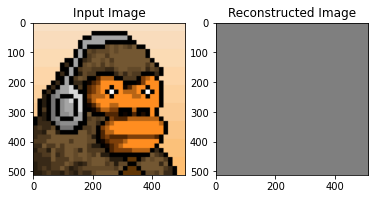

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load your input image here using a suitable image loading library
image = Image.open("/content/drive/MyDrive/VAE/train/3.png")#.resize((64, 64))

# Convert the image to a tensor
image_tensor = tf.convert_to_tensor(np.array(image))
#
image_tensor = tf.cast(image_tensor, tf.float32)

#normalize photo 
image_tensor = tf.map_fn(normalize,image_tensor)

# Add a batch dimension to the tensor
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Call vae.encode() on the input tensor to obtain mean and log variance of latent space
z_mean, z_log_var = vae.encode(image_tensor.numpy())

# Use mean and log variance to generate latent space vector using vae.reparameterize()
#z = vae.reparameterize(z_mean, z_log_var)

# Call vae.decode() on latent space vector to generate reconstructed image
reconstructed_image = vae.decode([z_mean,z_log_var])

#denormalize photo 
#reconstructed_image = tf.map_fn(denormalize,reconstructed_image)

# Convert reconstructed image tensor to a numpy array
reconstructed_image_array = reconstructed_image.numpy()

#convert to rgb
#reconstructed_image_array = cv2.cvtColor(reconstructed_image_array, cv2.COLOR_BGR2RGB)

# Visualize input image and reconstructed image side-by-side
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[1].imshow(reconstructed_image_array[0])
axes[1].set_title("Reconstructed Image")
plt.show()

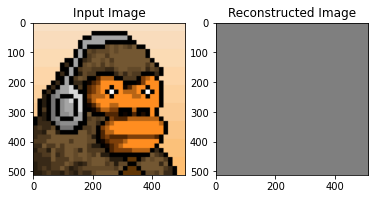

In [17]:
import numpy as np

arr = np.ones((1, 512, 512, 3))
z_mean, z_log_var = vae.encode(arr)
reconstructed_image = vae.decode([z_mean,z_log_var])
reconstructed_image_array = reconstructed_image.numpy()
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[1].imshow(reconstructed_image_array[0])
axes[1].set_title("Reconstructed Image")
plt.show()

In [18]:
reconstructed_image

<tf.Tensor: shape=(1, 512, 512, 3), dtype=float32, numpy=
array([[[[0.49990597, 0.49985793, 0.49988583],
         [0.49998295, 0.49981928, 0.49987784],
         [0.49992758, 0.49982935, 0.4998738 ],
         ...,
         [0.49998963, 0.49981636, 0.49988863],
         [0.49992764, 0.49982673, 0.49986902],
         [0.49999404, 0.49988702, 0.4999137 ]],

        [[0.49995404, 0.4998949 , 0.49982995],
         [0.49994415, 0.49986467, 0.49979803],
         [0.4999951 , 0.49986497, 0.49979177],
         ...,
         [0.49993443, 0.49984246, 0.49980006],
         [0.5000082 , 0.49986628, 0.49980375],
         [0.49995077, 0.49985394, 0.4998091 ]],

        [[0.49990788, 0.49986646, 0.4998318 ],
         [0.49998647, 0.49983788, 0.49981648],
         [0.4999133 , 0.49981058, 0.49975944],
         ...,
         [0.50001687, 0.49984068, 0.4998116 ],
         [0.4999166 , 0.4998111 , 0.49975812],
         [0.50002   , 0.49991673, 0.4998509 ]],

        ...,

        [[0.49995393, 0.49990842, 

In [17]:
tf.math.equal(z,z1)

<tf.Tensor: shape=(1, 786432), dtype=bool, numpy=array([[False, False, False, ..., False, False, False]])>

In [16]:
import cv2
from numpy import asarray
filepath = '/content/drive/MyDrive/VAE/train/1.png'
image = cv2.imread(filepath)
image = asarray(image)
image = np.expand_dims(image, axis=0)
z_mean,z_log_var = vae.encode(image)
z = vae.reparameterize(z_mean, z_log_var)

filepath = '/content/drive/MyDrive/VAE/train/2.png'
image = cv2.imread(filepath)
image = asarray(image)
image = np.expand_dims(image, axis=0)
z_mean1,z_log_var1 = vae.encode(image)
z1 = vae.reparameterize(z_mean1, z_log_var1)

import tensorflow as tf

print('image 1: ', z_mean, z_log_var, z)
print('image 2: ', z_mean1, z_log_var1, z1)

image 1:  tf.Tensor(
[[ 0.04439142 -0.04440323 -0.03754404 ...  0.074063   -0.02464271
   0.00668878]], shape=(1, 786432), dtype=float32) tf.Tensor(
[[ 0.01329378  0.00402711 -0.0173732  ... -0.10129126  0.03008308
   0.01919743]], shape=(1, 786432), dtype=float32) tf.Tensor(
[[ 1.0749962   1.7498881  -1.1259962  ...  0.82033926 -0.48016715
   0.14080909]], shape=(1, 786432), dtype=float32)
image 2:  tf.Tensor(
[[ 0.02631677 -0.04899019 -0.01684255 ...  0.04372918  0.00040385
   0.00374934]], shape=(1, 786432), dtype=float32) tf.Tensor(
[[-0.00070305 -0.00356203 -0.0119801  ... -0.06196291  0.01756138
   0.00873427]], shape=(1, 786432), dtype=float32) tf.Tensor(
[[-2.0110743   1.5530831  -0.7951173  ... -1.5860196  -0.31751066
  -0.46964175]], shape=(1, 786432), dtype=float32)
